# 第8週：分析PTT美食版吃到飽相關文章之詞彙關係

**Author**: 蔡睿澤  
**Date created**: 2023/04/04  
**Last modified**: 2023/04/10<br><br> 
本週課程為「文辭和文件分析」，目的為透過TF-IDF, N-gram等方法找出文章以及字詞間的關聯。在這個Jupyter Notebook中將會以美食版吃到飽相關文章做為分析資料。


## 大綱

1. 套件說明
2. 資料前處理
    - 2.1 基本資料介紹
    - 2.2 資料清理
    - 2.3 文章斷詞與整理
3. TF-IDF
    - 3.1 計算每篇文章的詞數
    - 3.2 計算tf-idf值
    - 3.3 檢視結果
4. 透過結巴斷詞與N-gram幫助建立字典
    - 4.1 Bigram
    - 4.2 Trigram
5. 使用自建字典
6. 建立Ngram預測模型
7. Bigram視覺化
8. Pairwise correlation
    - 8.1 找出相關性高的詞彙
    - 8.2 畫出關係圖
9. 計算文章相似度


## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- jieba: 中文斷詞套件。
- re: 正規表達式套件。
- math: 數學運算工具。
- collections: 提供額外的數據類型。
- matplotlib: 繪圖工具。
- networkx: 網絡圖建構、繪製工具。
- CountVectorizer, TfidfTransformer: sklearn中計算詞頻與tf-idf的套件。
- numpy.linalg: 矩陣與向量運算套件。

In [1]:
# pip install -U networkx

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm

In [3]:
plt.rcParams['font.sans-serif']=['SimHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示

In [4]:
# cloab 字體設定

# !wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
# matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
# matplotlib.rc('font', family='Taipei Sans TC Beta')

## 2. 資料前處理

### 2.1 基本資料介紹
資料來源：
+ 工作流程平台蒐集PTT 美食版(Food)文章
+ 關鍵字:「吃到飽」
+ 時間: 2020-01-10 ~ 2022-12-31
+ 資料筆數：共 1630 篇文章

In [5]:
#匯入資料
MetaData = pd.read_csv('./raw_data/zh_buffet_20_22.csv', encoding='UTF-8')
MetaData.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,[],111.250.1.231,2020-01-02 00:21:09,ptt
1,2,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02 16:42:10,justin81828,Food,餐廳名稱：乾杯\n\n 地址：ATT4FUN 乾杯\n 電話：02-87860808\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""KKyosuke"", ""...",118.169.82.96,2020-01-03 00:22:27,ptt
2,3,https://www.ptt.cc/bbs/Food/M.1577985452.A.477...,[食記]台北大安區六張犁站捷運小慧涼麵,2020-01-02 17:11:29,v84454058,Food,餐廳名稱：小慧涼麵\n 消費時間：2018年/11月起多訪\n 地址：台北市大安區臥...,[],123.194.196.149,2020-01-03 00:22:34,ptt


### 2.2 資料清理  
- 去除特殊字元與標點符號

In [6]:
# 移除網址格式
MetaData['sentence'] = MetaData.artContent.apply(lambda x: re.sub('(http|https)://.*', '', x))
# 只留下中文字
MetaData['sentence'] = MetaData.artContent.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '',x))
MetaData.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,[],111.250.1.231,2020-01-02 00:21:09,ptt,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...
1,2,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02 16:42:10,justin81828,Food,餐廳名稱：乾杯\n\n 地址：ATT4FUN 乾杯\n 電話：02-87860808\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""KKyosuke"", ""...",118.169.82.96,2020-01-03 00:22:27,ptt,餐廳名稱乾杯地址乾杯電話消費時間年月號事發經過元旦跟女朋友晚上訂了位以前都會點上等牛排吃過很...
2,3,https://www.ptt.cc/bbs/Food/M.1577985452.A.477...,[食記]台北大安區六張犁站捷運小慧涼麵,2020-01-02 17:11:29,v84454058,Food,餐廳名稱：小慧涼麵\n 消費時間：2018年/11月起多訪\n 地址：台北市大安區臥...,[],123.194.196.149,2020-01-03 00:22:34,ptt,餐廳名稱小慧涼麵消費時間年月起多訪地址台北市大安區臥龍街巷號電話營業時間週日公休每人平均價位...


### 2.3 文章斷詞與整理

In [7]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [8]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [9]:
data = MetaData.copy()
data['word'] = data.sentence.apply(getToken)

# 將word欄位展開
data = data.explode('word')

data.head(3)

Building prefix dict from /Users/brandon/Downloads/SMA_2021F-master/week8/dict/dict.txt.big ...
Loading model from cache /var/folders/wb/4p2wtwfn0hbfl5wk9721_6gm0000gn/T/jieba.uc572fb2daa7530b98cfc4603a57d335e.cache
Loading model cost 0.538 seconds.
Prefix dict has been built successfully.


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,[],111.250.1.231,2020-01-02 00:21:09,ptt,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,餐廳
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,[],111.250.1.231,2020-01-02 00:21:09,ptt,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,名稱
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,[],111.250.1.231,2020-01-02 00:21:09,ptt,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,咖哩


## 3. TF-IDF
TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度  
- **TF** (Term Frequency)：某一個詞彙在某一個文件中所出現的頻率  
    - TF = 詞彙在該文件中出現次數 / 該文件中詞彙總數  
- **IDF** (Inverse Document Frequent)：為文件數除以某特定詞彙有被多少文件所提及的數量取log  
    - IDF = log( 總文件數量 / 包含該詞彙的文件數量 ) 



### 3.1 計算每篇文章的 總詞彙數 與 各個詞彙數

In [10]:
# 每篇文章的總詞彙數
total_words = data.groupby(['artUrl'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,artUrl,total
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,115
1,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,78
2,https://www.ptt.cc/bbs/Food/M.1577985452.A.477...,243
3,https://www.ptt.cc/bbs/Food/M.1578120136.A.276...,211
4,https://www.ptt.cc/bbs/Food/M.1578125940.A.9AA...,357
...,...,...
1625,https://www.ptt.cc/bbs/Food/M.1671727552.A.F4D...,156
1626,https://www.ptt.cc/bbs/Food/M.1671812237.A.F57...,396
1627,https://www.ptt.cc/bbs/Food/M.1672065694.A.96C...,392
1628,https://www.ptt.cc/bbs/Food/M.1672150855.A.A0B...,18


In [11]:
# 計算各詞彙在各文章中出現的次數
word_count = data.groupby(['artUrl','word'],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)
word_count

,artUrl,word,count
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,一張,1
1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,一種,1
2,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不予,1
3,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不忙,1
4,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不辣,1
...,...,...,...
368675,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,點了,2
368676,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,點來,1
368677,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,點多,1
368678,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,點成,1


#### 合併需要的資料欄位
- 合併 **每個詞彙在每篇文章中出現的次數** 與 **每篇文章的詞數**

In [12]:
food_words = word_count.merge(total_words,on = 'artUrl',how = 'left')
food_words

,artUrl,word,count,total
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,一張,1,115
1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,一種,1,115
2,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不予,1,115
3,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不忙,1,115
4,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不辣,1,115
...,...,...,...,...
368675,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,點了,2,493
368676,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,點來,1,493
368677,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,點多,1,493
368678,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,點成,1,493


### 3.2 計算 tf-idf 值
- 以每篇文章爲單位，計算每個詞彙的 tf-idf 值  
    - tf-idf = tf * idf

In [13]:
# 計算tf
food_words_tf_idf = food_words.assign(tf = food_words.iloc[:,2]/food_words.iloc[:,3])
food_words_tf_idf.head()

,artUrl,word,count,total,tf
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,一張,1,115,0.008696
1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,一種,1,115,0.008696
2,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不予,1,115,0.008696
3,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不忙,1,115,0.008696
4,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不辣,1,115,0.008696


In [14]:
# 計算每個詞彙出現在幾篇文章中
idf_df = food_words.groupby(['word'],as_index=False).size()
food_words_tf_idf = food_words_tf_idf.merge(idf_df,on = 'word',how = 'left')
food_words_tf_idf.head()

,artUrl,word,count,total,tf,size
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,一張,1,115,0.008696,83
1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,一種,1,115,0.008696,250
2,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不予,1,115,0.008696,8
3,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不忙,1,115,0.008696,1
4,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不辣,1,115,0.008696,48


In [15]:
# 計算idf
food_words_tf_idf = food_words_tf_idf.assign(idf = food_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

food_words_tf_idf = food_words_tf_idf.drop(labels=['size'],axis=1)
food_words_tf_idf.head()

,artUrl,word,count,total,tf,idf
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,一張,1,115,0.008696,1.293110
1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,一種,1,115,0.008696,0.814248
2,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不予,1,115,0.008696,2.309098
3,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不忙,1,115,0.008696,3.212188
4,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不辣,1,115,0.008696,1.530946


In [16]:
# 計算tf*idf
food_words_tf_idf = food_words_tf_idf.assign(tf_idf = food_words_tf_idf.iloc[:,4] * food_words_tf_idf.iloc[:,5])
food_words_tf_idf.head()

,artUrl,word,count,total,tf,idf,tf_idf
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,一張,1,115,0.008696,1.293110,0.011244
1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,一種,1,115,0.008696,0.814248,0.007080
2,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不予,1,115,0.008696,2.309098,0.020079
3,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不忙,1,115,0.008696,3.212188,0.027932
4,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不辣,1,115,0.008696,1.530946,0.013313


### 3.3 檢視結果

In [17]:
# 選出每篇文章，tf-idf值最大的前五個詞
group = food_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(5, "tf_idf"))

In [18]:
group.loc[:,["word","tf_idf"]][0:15]

word    tf_idf
artUrl                                                                
https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4.... 22     咖哩  0.094473
                                                   50     混醬  0.055864
                                                   73     開封  0.047566
                                                   13     加飯  0.039269
                                                   15     印度  0.030696
https://www.ptt.cc/bbs/Food/M.1577983692.A.794.... 111    推到  0.082364
                                                   89     不爛  0.059208
                                                   90     乾杯  0.055661
                                                   144    面前  0.049004
                                                   94     元旦  0.041182
https://www.ptt.cc/bbs/Food/M.1577985452.A.477.... 224   小慧涼  0.079313
                                                   286    羽諾  0.078788
                                                   265    炒飯  0.040188
                                                   192  吃喝玩樂  0.019482
                                                   235    愛店  0.014657

#### 計算整個文集中較常 tf-idf 值高的字

In [19]:
# 從每篇文章挑選出tf-idf最大的前十個詞
(food_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(10) # 排序看前十名

,word,size
5527,燒肉,83
8331,韓式,78
5635,牛排,75
2527,壽司,62
5292,火鍋,49
2808,套餐,46
8781,麻辣鍋,45
5396,烤肉,44
8023,鍋物,38
5003,泰式,36


## 4. 透過結巴斷詞與N-gram幫助建立字典
N-gram 指文本中連續出現的n個語詞。 透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。  
N-gram範例：

In [20]:
token = jieba.lcut("中山資管全國第一")
token

['中山', '資管', '全國', '第一']

In [21]:
# 利用nltk的ngrams()
# Bigram
bigram  = ngrams(token, 2)
list(bigram)

[('中山', '資管'), ('資管', '全國'), ('全國', '第一')]

In [22]:
# Trigram
trigram  = ngrams(token, 3)
list(trigram)

[('中山', '資管', '全國'), ('資管', '全國', '第一')]

### 4.1 Bigram

In [23]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [24]:
food_bigram = MetaData.copy()

food_bigram["word"] = food_bigram.sentence.apply(bigram_getToken)
food_bigram = food_bigram.explode('word')
food_bigram.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,[],111.250.1.231,2020-01-02 00:21:09,ptt,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,餐廳 名稱
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,[],111.250.1.231,2020-01-02 00:21:09,ptt,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,名稱 咖哩
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,[],111.250.1.231,2020-01-02 00:21:09,ptt,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,咖哩 消費


#### 統計最常出現的bigram組合

In [25]:
# 計算每個組合出現的次數
food_bigram_count = food_bigram.groupby(["word"],as_index=False).size()
food_bigram_count.head()

,word,size
0,一一 介紹,7
1,一一 分享,1
2,一一 列出,1
3,一一 只能,1
4,一一 品嚐,2


In [26]:
# 清除包含英文或數字的bigram組合
fb_filter = list(food_bigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
food_bigram_count[fb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
335151,電話 營業時間,1271
195892,消費 時間,1169
346412,餐廳 名稱,1076
164994,時間 地址,1024
123713,平均 價位,766
183518,每人 平均,759
71021,可否 刷卡,619
171796,服務 人員,600
90999,地址 台北市,500
170199,有無 包廂,499


### 4.2 Trigram

In [27]:
# 設定 trigram 斷詞 function
def trigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [28]:
food_trigram = MetaData.copy()

food_trigram["word"] = food_trigram.sentence.apply(trigram_getToken)
food_trigram = food_trigram.explode('word')
food_trigram.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,[],111.250.1.231,2020-01-02 00:21:09,ptt,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,餐廳 名稱 咖哩
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,[],111.250.1.231,2020-01-02 00:21:09,ptt,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,名稱 咖哩 消費
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,[],111.250.1.231,2020-01-02 00:21:09,ptt,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,咖哩 消費 時間


#### 統計最常出現的trigram組合

In [29]:
# 計算每個組合出現的次數
food_trigram_count = food_trigram.groupby(["word"],as_index=False).size()
# 清除包含英文或數字的trigram組合
fb_filter = list(food_trigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
food_trigram_count[fb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
258533,消費 時間 地址,999
241326,每人 平均 價位,750
69519,刷卡 有無 包廂,432
92238,可否 刷卡 有無,427
47882,價位 可否 刷卡,396
161855,平均 價位 可否,392
217145,時間 地址 台北市,288
286676,營業時間 每人 平均,272
442582,電話 營業時間 每人,268
75052,包廂 推薦 菜色,248


從上面的 bigram 和 trigram 的結果中，我們發現"餐廳 名稱","服務 人員"等詞可以組合在一起，所以我們增加自定義字典來幫助斷詞能更準確。  
我們將詞彙整理好存在 dict 文件夾中的 buffet_lexicon.txt 中。

## 5. 使用自建字典

In [30]:
# 新增吃到飽相關自定義字典
jieba.load_userdict('./dict/buffet_lexicon.txt')

**使用自建辭典進行斷詞與計算**

In [31]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

In [32]:
# 再次計算各詞彙在各文章中出現的次數
word_count2 = data2.groupby(['artUrl','word'],as_index=False).size()
word_count2.rename(columns={'size': 'count'}, inplace=True)
word_count2.head(10)

,artUrl,word,count
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,一張,1
1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,一種,1
2,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不予,1
3,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不忙,1
4,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不辣,1
5,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,例年,1
6,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,便宜,1
7,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,保留,1
8,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,偏辣,1
9,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,價位,1


接下來的步驟就跟上面一樣，這裡省略

## 6. 建立Ngram預測模型
引入Markov假設，也就是當前的這個字僅僅與前幾個有限的字相關   
$$P(w_i|w_1,...,w_{i-1})=P(w_i|w_{i-m+1},...,w_{i-1})$$  
bi-gram (m=2):
$$ P(w_i|w_{i-1})=\frac {count(w_{i-1},w_i)} {count(w_{i-1})} $$   
tri-gram (m=3):  
$$ P(w_i|w_{i-2},w_{i-1})=\frac {count(w_{i-2},w_{i-1},w_i)} {count(w_{i-2},w_{i-1})} $$   



參考網站：
- [N-gram Language Models](https://towardsdatascience.com/n-gram-language-models-af6085435eeb)
- [自然語言處理 — 使用 N-gram 實現輸入文字預測](https://medium.com/%E6%89%8B%E5%AF%AB%E7%AD%86%E8%A8%98/%E8%87%AA%E7%84%B6%E8%AA%9E%E8%A8%80%E8%99%95%E7%90%86-%E4%BD%BF%E7%94%A8-n-gram-%E5%AF%A6%E7%8F%BE%E8%BC%B8%E5%85%A5%E6%96%87%E5%AD%97%E9%A0%90%E6%B8%AC-10ac622aab7a)
- [自然語言處理中N-Gram模型介紹](https://zhuanlan.zhihu.com/p/32829048)

---
**以Bi-gram為例： 中山 __ 該填甚麼?**  
[ ["中山","資管","全國","第一"], ["歡迎","來到","中山","大學"], ["中山","資管","碩士","開放","報名"] ]  
$$ p(w|中山) = \frac {count(中山,w)} {count(中山)} $$
           
$$ p(資管|中山) = \frac {2} {3} $$
$$ p(大學|中山) = \frac {1} {3} $$

In [33]:
test_list = [["中山","資管","全國","第一"],
           ["歡迎","來到","中山","大學"],
           ["中山","資管","碩士","開放","報名"]]

In [34]:
N=2
ngram_prediction = dict()
total_grams = list()
words = list()
Word = namedtuple('Word', ['word', 'prob'])

for doc in test_list:
    # 加上開頭和結尾 tag
    split_words = ['<s>'] + list(doc) + ['</s>']
    # 計算分子
    [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
    print(total_grams)
    # 計算分母
    [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
    print(words)
    print('')
        
total_word_counter = Counter(total_grams)
word_counter = Counter(words)

[('<s>', '中山'), ('中山', '資管'), ('資管', '全國'), ('全國', '第一'), ('第一', '</s>')]
[('<s>',), ('中山',), ('資管',), ('全國',), ('第一',), ('</s>',)]

[('<s>', '中山'), ('中山', '資管'), ('資管', '全國'), ('全國', '第一'), ('第一', '</s>'), ('<s>', '歡迎'), ('歡迎', '來到'), ('來到', '中山'), ('中山', '大學'), ('大學', '</s>')]
[('<s>',), ('中山',), ('資管',), ('全國',), ('第一',), ('</s>',), ('<s>',), ('歡迎',), ('來到',), ('中山',), ('大學',), ('</s>',)]

[('<s>', '中山'), ('中山', '資管'), ('資管', '全國'), ('全國', '第一'), ('第一', '</s>'), ('<s>', '歡迎'), ('歡迎', '來到'), ('來到', '中山'), ('中山', '大學'), ('大學', '</s>'), ('<s>', '中山'), ('中山', '資管'), ('資管', '碩士'), ('碩士', '開放'), ('開放', '報名'), ('報名', '</s>')]
[('<s>',), ('中山',), ('資管',), ('全國',), ('第一',), ('</s>',), ('<s>',), ('歡迎',), ('來到',), ('中山',), ('大學',), ('</s>',), ('<s>',), ('中山',), ('資管',), ('碩士',), ('開放',), ('報名',), ('</s>',)]



In [35]:
# 分子
total_word_counter

Counter({('<s>', '中山'): 2,
         ('中山', '資管'): 2,
         ('資管', '全國'): 1,
         ('全國', '第一'): 1,
         ('第一', '</s>'): 1,
         ('<s>', '歡迎'): 1,
         ('歡迎', '來到'): 1,
         ('來到', '中山'): 1,
         ('中山', '大學'): 1,
         ('大學', '</s>'): 1,
         ('資管', '碩士'): 1,
         ('碩士', '開放'): 1,
         ('開放', '報名'): 1,
         ('報名', '</s>'): 1})

In [36]:
# 分母
word_counter

Counter({('<s>',): 3,
         ('中山',): 3,
         ('資管',): 2,
         ('全國',): 1,
         ('第一',): 1,
         ('</s>',): 3,
         ('歡迎',): 1,
         ('來到',): 1,
         ('大學',): 1,
         ('碩士',): 1,
         ('開放',): 1,
         ('報名',): 1})

In [37]:
for key in total_word_counter:
    word = ''.join(key[:N-1])
    if word not in ngram_prediction:
        ngram_prediction.update({word: set()})

    # 算出預測機率，新增至 ngram_prediction
    next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
    w = Word(key[-1], '{:.3g}'.format(next_word_prob))
    ngram_prediction[word].add(w)

In [38]:
ngram_prediction

{'<s>': {Word(word='中山', prob='0.667'), Word(word='歡迎', prob='0.333')},
 '中山': {Word(word='大學', prob='0.333'), Word(word='資管', prob='0.667')},
 '資管': {Word(word='全國', prob='0.5'), Word(word='碩士', prob='0.5')},
 '全國': {Word(word='第一', prob='1')},
 '第一': {Word(word='</s>', prob='1')},
 '歡迎': {Word(word='來到', prob='1')},
 '來到': {Word(word='中山', prob='1')},
 '大學': {Word(word='</s>', prob='1')},
 '碩士': {Word(word='開放', prob='1')},
 '開放': {Word(word='報名', prob='1')},
 '報名': {Word(word='</s>', prob='1')}}

**使用我們的吃到飽資料集**

In [39]:
data3 = MetaData.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()

In [40]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # 加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [41]:
# Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

**預測下一個出現的詞**

In [42]:
text = '喜歡'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 口味, probability: 0.0132
next word: 朋友, probability: 0.0112
next word: 口感, probability: 0.00951
next word: 海鮮, probability: 0.00951
next word: 牛肉, probability: 0.0091


In [43]:
text = '提供'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 白飯, probability: 0.0163
next word: 免費, probability: 0.0116
next word: 兒童, probability: 0.00945
next word: 四種, probability: 0.00859
next word: 兩種, probability: 0.00859


## 7. Bigram視覺化

In [44]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [45]:
food_bigram2 = MetaData.copy()
food_bigram2["word"] = food_bigram2.sentence.apply(bigram_getToken_dict)

In [46]:
food_bigram2 = food_bigram2.explode('word')
food_bigram2.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,[],111.250.1.231,2020-01-02 00:21:09,ptt,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,餐廳名稱 咖哩
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,[],111.250.1.231,2020-01-02 00:21:09,ptt,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,咖哩 消費
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,[],111.250.1.231,2020-01-02 00:21:09,ptt,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,消費 時間


In [47]:
# 看一下bigramfdist內容
bigramfdist.most_common(5)

[(('電話', '營業時間'), 1271),
 (('消費', '時間'), 1169),
 (('時間', '地址'), 1024),
 (('平均', '價位'), 766),
 (('每人', '平均'), 759)]

In [48]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}

In [49]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

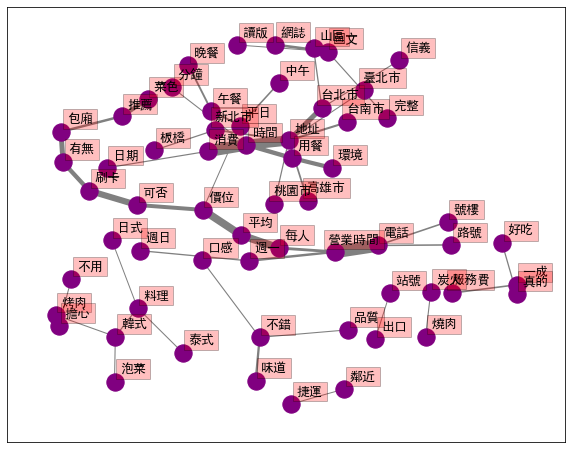

In [50]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## 8. Pairwise correlation
計算兩個詞彙間的相關性 Phi相關係數(Phi coefficient)  
<img src="./img/pic1.png" style="float:left;" width="50%">  
<img src="./img/pic2.png" style="float:left;" width="25%">

In [51]:
# 取常一起出現的bigram pair 前1500筆
b = {k:v for k,v in bigramfdist.most_common(1500)}
# b.items()

In [52]:
# 建立DataFrame
bigram_df = pd.DataFrame(list(b), columns=['word','word2']).assign(n=b.values())

In [53]:
# 每個bigram組合的次數
bigram_df.head()

,word,word2,n
0,電話,營業時間,1271
1,消費,時間,1169
2,時間,地址,1024
3,平均,價位,766
4,每人,平均,759


In [54]:
# 詞彙在各文章中出現的次數
word_count2.head()

,artUrl,word,count
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,一張,1
1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,一種,1
2,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不予,1
3,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不忙,1
4,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,不辣,1


In [55]:
#計算phi值
def phi_cor(df):
    # total x
    nx = len(set(word_count2[word_count2["word"]==df["word"]]["artUrl"]))
    tnx = len(MetaData)-nx
    # total y
    ny = len(set(word_count2[word_count2["word"]==df["word2"]]["artUrl"]))
    tny = len(MetaData)-ny
    # 有x 有y
    x_ls = list(word_count2[word_count2["word"]==df["word"]]["artUrl"]) #單獨有x
    y_ls = list(word_count2[word_count2["word"]==df["word2"]]["artUrl"]) #單獨有y
    nxy = len(set(x_ls)&set(y_ls)) #取交集
    # 有x 沒有y
    nxo = nx-nxy
    # 沒有x 沒有y
    uxy = set(x_ls)|set(y_ls) #取聯集
    noo = len(set(list(MetaData["artUrl"]))-uxy) #取差集:全-有x有y
    # 沒有x 有y
    noy = ny-nxy
    # print(nx,ny,tny,tnx,nxy,noo,nxo,noy)
    phi = (nxy*noo-nxo*noy)/math.sqrt(nx*ny*tny*tnx)
    
    return phi

In [56]:
bigram_df["cor"] = bigram_df.apply(phi_cor, axis=1)
bigram_df = bigram_df[bigram_df["word"]!=bigram_df["word2"]]

In [57]:
bigram_df.head()

,word,word2,n,cor
0,電話,營業時間,1271,0.472789
1,消費,時間,1169,0.542439
2,時間,地址,1024,0.425880
3,平均,價位,766,0.537018
4,每人,平均,759,0.827147


### 8.1 和 冰淇淋, 口感 相關性最高的 10 個詞彙

In [58]:
ice_sum = bigram_df[(bigram_df["word"]=="冰淇淋")].sort_values(by=['cor'], ascending = False).head(10)
taste_sum = bigram_df[(bigram_df["word"]=="口感")].sort_values(by=['cor'], ascending = False).head(10)

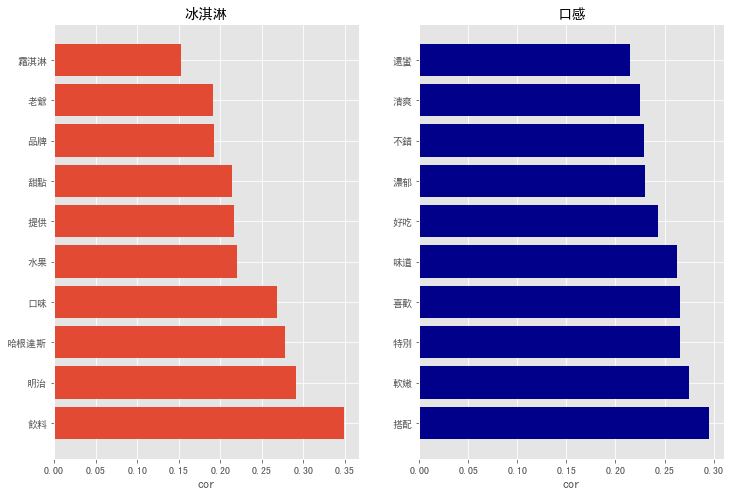

In [59]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('冰淇淋')
plt.xlabel('cor')
plt.barh(ice_sum['word2'],ice_sum['cor'])

plt.subplot(122)
plt.title('口感')
plt.xlabel('cor')
plt.barh(taste_sum['word2'],taste_sum['cor'],color="darkblue")


plt.show()

### 8.2 使用詞彙關係圖畫出相關性大於0.4的組合

In [60]:
bigram_df[bigram_df["cor"]>0.4]

,word,word2,n,cor
0,電話,營業時間,1271,0.472789
1,消費,時間,1169,0.542439
2,時間,地址,1024,0.425880
3,平均,價位,766,0.537018
4,每人,平均,759,0.827147
...,...,...,...,...
1433,雀巢,檸檬茶,15,0.473257
1437,上班,偷看,15,0.640476
1457,本篇,廠商,15,0.484333
1458,廠商,邀約,15,0.603693


In [61]:
word_cors = bigram_df[bigram_df["cor"]>0.4]
word_cors.reset_index(inplace=True, drop=True)

In [62]:
import networkx as nx
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(word_cors)):
    g.add_edge(word_cors["word"][i], word_cors["word2"][i], weight=word_cors["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*10 for w in  g.edges(data=True)]

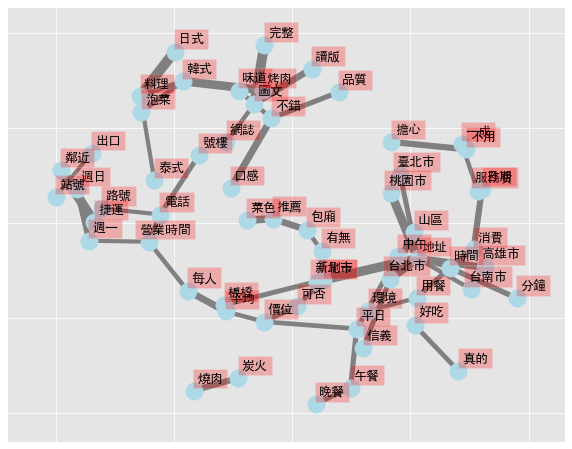

In [63]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## 9. 計算文章相似度
以TF-IDF的結果當作文章的向量，計算 Cosine Similarity 找出相似的文章  
<img src="./img/pic3.PNG" style="float:left;" width="50%">  

In [64]:
data_cos= MetaData.copy()
data_cos = data_cos.loc[:,["artTitle","artDate","artUrl","sentence"]]
# 需要改成使用空格連接斷好的詞
data_cos['word'] = data_cos.sentence.apply(getToken).map(' '.join)
data_cos.head(3)

,artTitle,artDate,artUrl,sentence,word
0,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,餐廳名稱 咖哩 消費 時間 例年 提供 文章 不予 保留 多訪 綜合 心得 標上 時間 地址...
1,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02 16:42:10,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,餐廳名稱乾杯地址乾杯電話消費時間年月號事發經過元旦跟女朋友晚上訂了位以前都會點上等牛排吃過很...,餐廳名稱 乾杯 地址 乾杯 電話 消費 時間 年月號 事發 元旦 女朋友 晚上 會點 牛排 ...
2,[食記]台北大安區六張犁站捷運小慧涼麵,2020-01-02 17:11:29,https://www.ptt.cc/bbs/Food/M.1577985452.A.477...,餐廳名稱小慧涼麵消費時間年月起多訪地址台北市大安區臥龍街巷號電話營業時間週日公休每人平均價位...,餐廳名稱 小慧涼 消費 時間 起多訪 地址 台北市 大安區 臥龍 街巷 電話 營業時間 週日...


In [65]:
# Bag of Word
# 篩選至少出現在5篇文章以上的詞彙
vectorizer = CountVectorizer(min_df=5)
X = vectorizer.fit_transform(data_cos["word"])
vocabulary = vectorizer.get_feature_names_out()
# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一一,一丁,一下下,一下子,一不小心,一中,一串,一二,一人,一人份,...,齊全,齊漲,龍膽,龍蝦,龍蝦肉,龍豚,龍頭,龍鬚菜,龜山,龜苓膏
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1625,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1626,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
1627,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1628,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
transformer = TfidfTransformer()  
print(transformer) 
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  
# print(tfidf.toarray())

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


,一一,一丁,一下下,一下子,一不小心,一中,一串,一二,一人,一人份,...,齊全,齊漲,龍膽,龍蝦,龍蝦肉,龍豚,龍頭,龍鬚菜,龜山,龜苓膏
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.048559,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053091,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
# 計算 cosine_similarity
def cosine_similarity(vector):
    cos_list = []
    for i in tfidf.toarray():
        score = np.dot(vector, i)  / (norm(vector) * norm(i))
        cos_list.append(score)
    df = pd.DataFrame(cos_list, columns=["cos_similarity"])
    return df

找和第一篇文章相似的其他文章

In [68]:
print(tfidf.toarray()[1])
cos_df = cosine_similarity(tfidf.toarray()[1])

[0. 0. 0. ... 0. 0. 0.]


/var/folders/wb/4p2wtwfn0hbfl5wk9721_6gm0000gn/T/ipykernel_19829/1312599743.py:5: RuntimeWarning: invalid value encountered in double_scalars
  score = np.dot(vector, i)  / (norm(vector) * norm(i))


In [69]:
# 第一篇文章和其他文章的相似程度
cos_df.head(10)

,cos_similarity
0,0.009713
1,1.000000
2,0.024145
3,0.064387
4,0.021908
5,0.029325
6,0.027809
7,0.029028
8,0.011565
9,0.016727


In [70]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
# cos_df.head()
cos_df.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
1,1.000000,[抱怨]ATT4FUN乾杯點沙朗多注意,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...
1127,0.179795,[食記]台中嵐山熟成牛かつ專売-台中西屯青海店,https://www.ptt.cc/bbs/Food/M.1637840280.A.CA5...
1577,0.176333,[食記]桃園中壢-中原商圈平價牛排-超牛牛排,https://www.ptt.cc/bbs/Food/M.1667703424.A.290...
762,0.155901,[食記]日本DenverPremium牛排,https://www.ptt.cc/bbs/Food/M.1612364564.A.1A4...
151,0.154861,[食記]台北信義老乾杯和牛伊比利豬豪華燒肉!,https://www.ptt.cc/bbs/Food/M.1585735425.A.EA7...
1504,0.151780,[食記]高雄夢時代-點主餐享自助吧★米塔牛排,https://www.ptt.cc/bbs/Food/M.1662265969.A.48F...
426,0.151238,[食記]『台北』有點失望的君品酒店雲軒西餐廳牛,https://www.ptt.cc/bbs/Food/M.1597576371.A.C71...
268,0.149907,[食記]高雄達樂斯牛排自由店很有誠意的沙拉吧,https://www.ptt.cc/bbs/Food/M.1590850799.A.AF7...
330,0.148632,[食記]高雄光華夜市大Q牛排,https://www.ptt.cc/bbs/Food/M.1593597762.A.0DD...
1558,0.140639,[食記]高雄.湖內-樂點平價牛排,https://www.ptt.cc/bbs/Food/M.1666070799.A.932...
